In [ ]:
# นำเข้าไลบรารี
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Diamonds_Prices.csv")

df =df.sort_values(by=['price'])

df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
df.tail()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
27745,27746,2.00,Very Good,H,SI1,62.8,57.0,18803,7.95,8.00,5.01
27746,27747,2.07,Ideal,G,SI2,62.5,55.0,18804,8.20,8.13,5.11
27747,27748,1.51,Ideal,G,IF,61.7,55.0,18806,7.37,7.41,4.56
27748,27749,2.00,Very Good,G,SI1,63.5,56.0,18818,7.90,7.97,5.04
27749,27750,2.29,Premium,I,VS2,60.8,60.0,18823,8.50,8.47,5.16


In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
carat,0
cut,0
color,0
clarity,0
depth,0
table,0
price,0
x,0
y,0


In [ ]:
# ลบคอลัมน์ที่ไม่ต้องการ เช่น "Unnamed: 0" (ถ้ามี) และคอลัมน์อื่นๆ ที่ไม่ใช้
df = df.drop(columns="Unnamed: 0",errors="ignore")  # ใช้ errors="ignore" ในกรณีที่ไม่มีคอลัมน์นี้

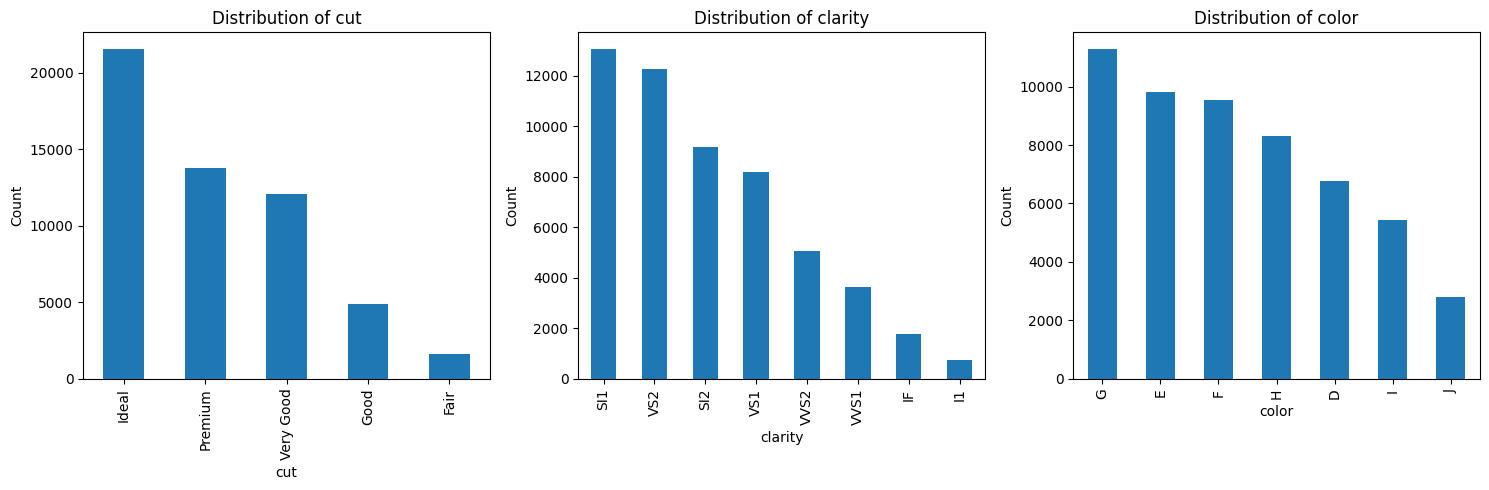

In [ ]:
text_features = ["cut", "clarity", "color"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create 1 row, 3 columns of subplots

for i, feature in enumerate(text_features):
    df[feature].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

<Axes: >

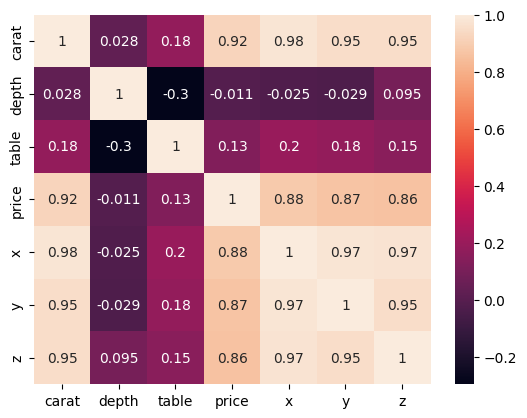

In [ ]:
sns.heatmap(df.corr(numeric_only = True),annot = True)

In [ ]:
# ลบ depth เพราะมีความสัมพันธ์ที่ต่ำมากกับ price
df = df.drop(columns = 'depth')

In [ ]:
df.describe()

,carat,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,0.797935,57.457251,3932.734294,5.731158,5.734526,3.538730
std,0.473999,2.234549,3989.338447,1.121730,1.142103,0.705679
min,0.200000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,5.010000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [ ]:
# --- จัดการกับ outlier ---
def remove_outliers(df):
    for column in df.select_dtypes(include=['float64', 'int64']):
        q1, q3 = df[column].quantile([0.25, 0.75])
        iqr = q3 - q1  # Interquartile Range
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr
        # กรองเฉพาะค่าที่อยู่ในช่วงที่กำหนด
        df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
    return df

# ลบ outlier
df = remove_outliers(df)
df.describe()

,carat,table,price,x,y,z
count,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000
mean,0.705944,57.331156,3020.028443,5.544631,5.548141,3.426038
std,0.363307,2.073751,2585.556382,0.965192,0.958509,0.598253
min,0.200000,52.000000,326.000000,3.730000,3.680000,1.410000
25%,0.380000,56.000000,898.000000,4.650000,4.660000,2.860000
50%,0.610000,57.000000,2068.500000,5.480000,5.490000,3.370000
75%,1.010000,59.000000,4532.250000,6.400000,6.400000,3.970000
max,2.000000,63.500000,11021.000000,8.270000,8.270000,5.370000


In [ ]:
# กำหนด Feature และ Target สำหรับโมเดล
# ให้คอลัมน์ 'price' คือ Target

features = ["carat", "cut", "color", "clarity", "table", "x", "y", "z"]
target = "price"

X = df[features]
y = df[target]

# แยกคอลัมน์ตัวเลขและ categorical เพื่อเตรียม ColumnTransformer

num_features = ["carat", "table", "x", "y", "z"]
cat_features = ["cut", "color", "clarity"]

preprocessor = make_column_transformer(
    (StandardScaler (), num_features),
    (OneHotEncoder(handle_unknown="ignore"), cat_features),
    remainder="drop"
)

In [ ]:
# สร้าง Pipeline สำหรับแต่ละโมเดล

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Pipeline
rf_pipeline = make_pipeline(
    preprocessor,
    RandomForestRegressor(
    n_estimators=200,
    max_depth=11,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
  )
)
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['carat', 'table', 'x', 'y',
                                                   'z']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=11, min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=200,
                                       random_state=42))])

In [ ]:
# SVR Pipeline
svr_pipeline = make_pipeline(
     preprocessor,
     SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.1, max_iter=10000)
 )

svr_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['carat', 'table', 'x', 'y',
                                                   'z']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('svr', SVR(C=100, gamma=0.01, max_iter=10000))])

In [ ]:
# Evaluate models
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_svr = svr_pipeline.predict(X_test)

rf_metrics = {
    "R²": r2_score(y_test, y_pred_rf),
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_rf))
}

svr_metrics = {
    "R²": r2_score(y_test, y_pred_svr),
    "MAE": mean_absolute_error(y_test, y_pred_svr),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_svr))
}
rf_metrics,svr_metrics

({'R²': 0.9739229176575742,
  'MAE': 245.8592752541408,
  'RMSE': 418.4168166703471},
 {'R²': 0.9126820013403972,
  'MAE': 466.3283085993305,
  'RMSE': 765.652171140958})

In [ ]:
joblib.dump(rf_pipeline, "diamond_price_model_rf.pkl")
joblib.dump(svr_pipeline, "diamond_price_model_svr.pkl")


['diamond_price_model_svr.pkl']

In [ ]:
# Testing
# Feature columns based on your dataset
feature_columns = ["carat", "cut", "color", "clarity", "table", "x", "y", "z"]

# Define possible categorical values (as used in training)
cut_options = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
color_options = ["D", "E", "F", "G", "H", "I", "J"]
clarity_options = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

# Function to generate a single random diamond sample
def generate_random_diamond():
    return {
        "carat": np.random.uniform(0.5, 1.3),
        "cut": np.random.choice(["Ideal", "Premium", "Very Good", "Good", "Fair"],
                                             p=[0.40, 0.25, 0.22, 0.10, 0.03]),
        "color": np.random.choice(["G", "E", "F", "H", "I", "D", "J"],
                                             p=[0.20, 0.18, 0.17, 0.15, 0.12, 0.10, 0.08]),
        "clarity": np.random.choice(["SI1", "VS2", "SI2", "VS1", "VVS2", "VVS1", "IF", "I1"],
                                                   p=[0.28, 0.27, 0.18, 0.15, 0.07, 0.035, 0.01, 0.005]),
        "table": np.random.uniform(56, 59),
        "x": np.random.uniform(4.75, 6.5),
        "y": np.random.uniform(4.7, 6.5),
        "z": np.random.uniform(2.8, 4)
    }

# Generate 10 random diamond samples for testing
random_diamonds = [generate_random_diamond() for _ in range(5)]
random_diamonds = pd.DataFrame(random_diamonds)
random_test_rf = rf_pipeline.predict(random_diamonds)
random_test_svr = svr_pipeline.predict(random_diamonds)


# Display the test dataset
print("----------------rf--------------")
print(random_test_rf)
print("----------------svr--------------")
print(random_test_svr)

----------------rf--------------
[4347.64183753 2575.1734303  1288.46630226 2813.00076101 2824.70843674]
----------------svr--------------
[3233.50324012 1633.21973741  822.90469617 1370.79452666 3184.00559575]
